Modeling and Evaluation Notebook:

Pipeline Setup
Train/Test Split or 5-fold cross-validation
Models:
- Logistic Regression baseline 
- Additional models: Random Forest, Gradient Boosting (XGBoost), Neural Network, SVM with RBF Kernel
- Super additional models: DecisionTree ("low end"), Genetic Algorithm ("high end")
Evaluation (accuracy, AUC, Precision, Recall, F1)
Debiasing method + fairness metrics
Reflection and interpretation

Pipeline Setup:

In [6]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

# 2. Load Data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# 3. Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'accuracy': make_scorer(accuracy_score)
}

# 4. Create pipelines for each model
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}



Pipeline Setup: 5-fold crossvalidation
Use StratifiedKfold to ensure that each fold in the cross-validation process has approximately the same proportion of target classes (recidivist vs. non-recidivist) as the full dataset. 
The is_recid target is imbalanced (around 30–35% positive class).

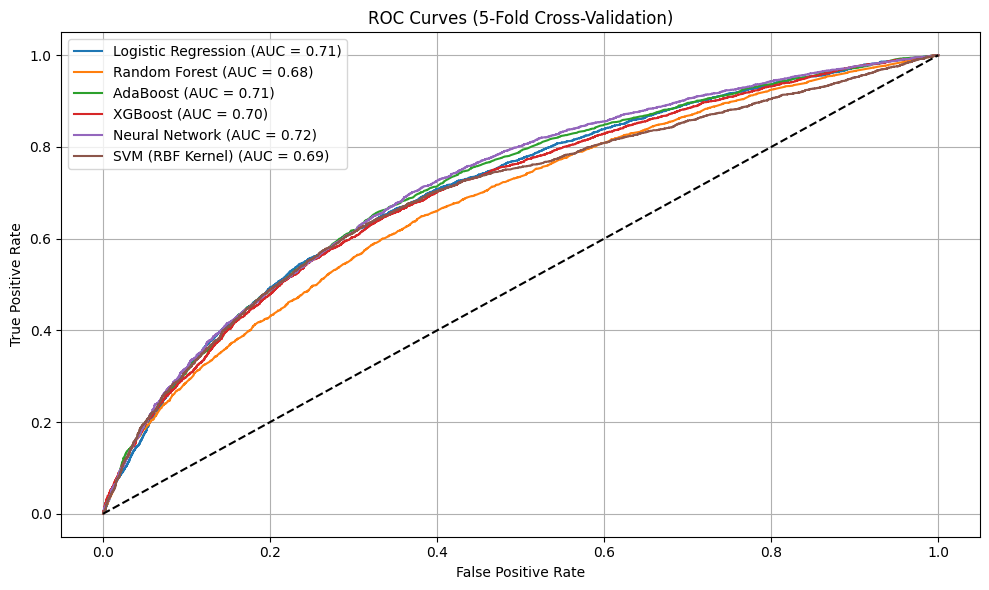

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.689,0.645,0.271,0.381,0.707
1,Random Forest,0.662,0.526,0.470,0.496,0.678
2,AdaBoost,0.692,0.596,0.402,0.480,0.712
3,XGBoost,0.691,0.589,0.423,0.492,0.702
4,Neural Network,0.698,0.616,0.386,0.475,0.717
5,SVM (RBF Kernel),0.690,0.634,0.296,0.404,0.693


In [33]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Initialize 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Use StratifiedKfold for imbalanced classes

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)

    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_with_adaboost.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_5-foldcv.csv", index=False)
results_df



Pipeline Setup: alternatively 80/20 Train/Test Split

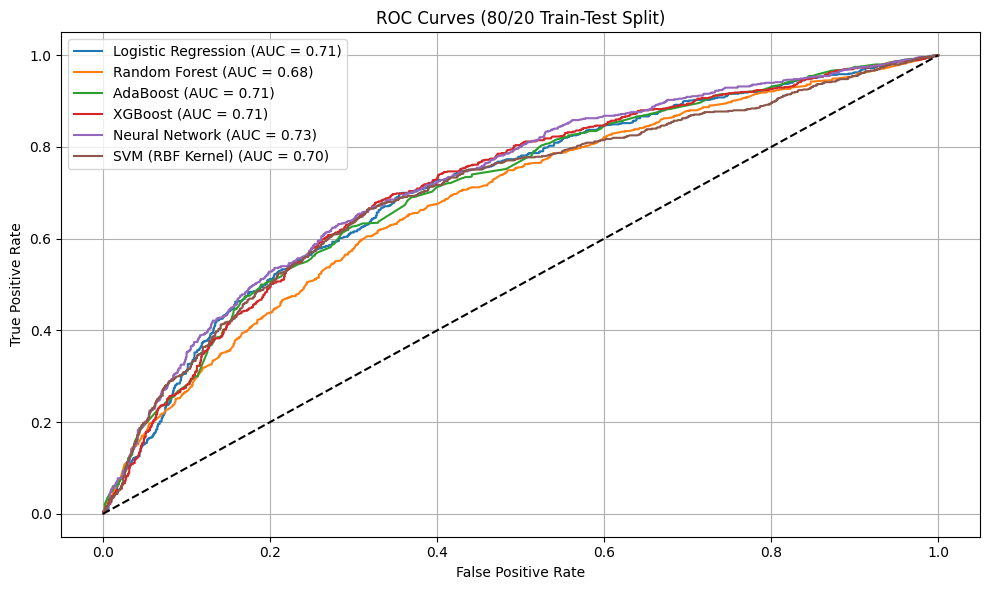

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.690,0.638,0.284,0.393,0.711
1,Random Forest,0.665,0.529,0.493,0.510,0.683
2,AdaBoost,0.695,0.604,0.401,0.482,0.709
3,XGBoost,0.696,0.600,0.423,0.496,0.714
4,Neural Network,0.706,0.635,0.397,0.489,0.725
5,SVM (RBF Kernel),0.695,0.651,0.299,0.410,0.702


In [32]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Perform 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Train-Test Split)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_80-20split.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_80-20ttsplit.csv", index=False)
results_df



Hyperparameter Tuning: 
Include GridSearch for each model. 

Tuning Logistic Regression...
Tuning Random Forest...
Tuning AdaBoost...
Tuning XGBoost...
Tuning Neural Network...
Tuning SVM (RBF Kernel)...


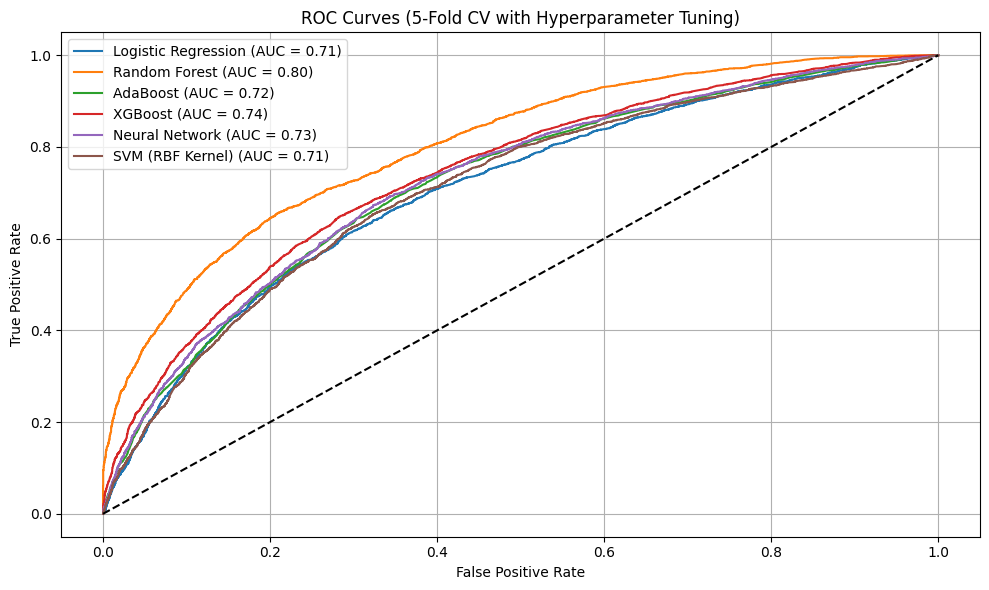

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.689,0.645,0.269,0.379,0.708,{'clf__C': 10}
1,Random Forest,0.752,0.745,0.457,0.566,0.803,"{'clf__max_depth': 10, 'clf__min_samples_split..."
2,AdaBoost,0.696,0.612,0.384,0.472,0.723,"{'clf__learning_rate': 0.5, 'clf__n_estimators..."
3,XGBoost,0.712,0.635,0.438,0.518,0.742,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,Neural Network,0.702,0.624,0.395,0.484,0.727,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
5,SVM (RBF Kernel),0.688,0.639,0.273,0.383,0.711,"{'clf__C': 1, 'clf__gamma': 0.01}"


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
base_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Define hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}

# Placeholder for storing results
results = []
plt.figure(figsize=(10, 6))

# Perform GridSearchCV for each model
for name in base_models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=cv, scoring="roc_auc", n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_

    # Predict and evaluate
    y_proba = best_model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)

    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold CV with Hyperparameter Tuning)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_cv_tuned.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_cv_tuned_results.csv", index=False)
results_df




Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for AdaBoost...
Running GridSearchCV for XGBoost...
Running GridSearchCV for Neural Network...
Running GridSearchCV for SVM (RBF Kernel)...


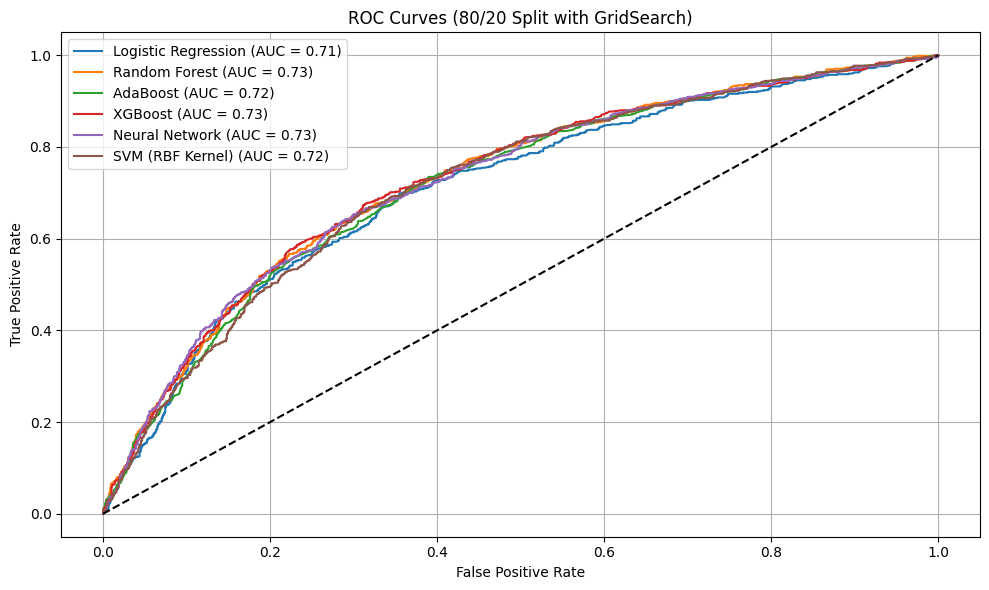

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.690,0.638,0.284,0.393,0.711,{'clf__C': 1}
1,Random Forest,0.698,0.615,0.393,0.480,0.727,"{'clf__max_depth': 10, 'clf__n_estimators': 200}"
2,AdaBoost,0.696,0.610,0.391,0.476,0.719,"{'clf__learning_rate': 0.5, 'clf__n_estimators..."
3,XGBoost,0.705,0.621,0.428,0.507,0.728,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,Neural Network,0.708,0.637,0.409,0.498,0.725,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
5,SVM (RBF Kernel),0.683,0.642,0.239,0.348,0.719,"{'clf__C': 1, 'clf__gamma': 0.01}"


In [30]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# Load dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models and parameter grids
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

param_grids = {
    "Logistic Regression": {"clf__C": [0.01, 0.1, 1, 10]},
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}

# Model training and evaluation
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Split with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_80-20split_tuned.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_80-20ttsplit_tuned_results.csv", index=False)
results_df

Compare tuned models for selection of the two best models: 

In [37]:
import pandas as pd

# Load both performance result CSVs
df_cv = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")
df_split = pd.read_csv("../reports/model_performance_comparison_80-20ttsplit_tuned_results.csv")

# Add source column for clarity
df_cv["Setup"] = "5-Fold CV"
df_split["Setup"] = "80/20 Split"

# Combine for comparison
combined_df = pd.concat([df_cv, df_split], ignore_index=True)

# Compare average F1, Recall, Precision, Accuracy across setups
summary = combined_df.groupby("Setup")[["F1 Score", "Recall", "Precision", "Accuracy"]].mean().round(3)

summary


,F1 Score,Recall,Precision,Accuracy
Setup,,,,
5-Fold CV,0.467,0.369,0.650,0.706
80/20 Split,0.450,0.357,0.627,0.697


As performances from the tuned 5-fold cross-validation are best, this setup will be selected for selection of the best models. 
Selection logic alternative A priorities: F1 → Precision → Recall → Accuracy

In [43]:
# Model selection criteria: F1 > Precision > Recall > Accuracy

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_a = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric (higher = better)
ranked_df_a["F1_rank"] = ranked_df_a["F1 Score"].rank(ascending=False, method="min")
ranked_df_a["Precision_rank"] = ranked_df_a["Precision"].rank(ascending=False, method="min")
ranked_df_a["Recall_rank"] = ranked_df_a["Recall"].rank(ascending=False, method="min")
ranked_df_a["Accuracy_rank"] = ranked_df_a["Accuracy"].rank(ascending=False, method="min")

# Weighted score: F1 (highest priority), then Recall, then Precision, then Accuracy
ranked_df_a["Overall_rank_A"] = (
    ranked_df_a["F1_rank"] * 1 +
    ranked_df_a["Precision_rank"] * 2 +
    ranked_df_a["Recall_rank"] * 3 +
    ranked_df_a["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_A = ranked_df_a.sort_values("Overall_rank_A").head(2)

# Combine with baseline
selected_models_A = pd.concat([baseline_model, best_models_A], ignore_index=True)
print("Alternative A - Top Models (F1 > Precision > Recall > Accuracy):")
print(selected_models_A[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])


Alternative A - Top Models (F1 > Precision > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.689      0.645   0.269     0.379  0.708
1        Random Forest     0.752      0.745   0.457     0.566  0.803
2              XGBoost     0.712      0.635   0.438     0.518  0.742


Selection logic alternative B priorities: Precision → F1 → Recall → Accuracy

In [42]:
# Model selection criteria: (Precision > F1 > Recall > Accuracy)

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_b = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric
ranked_df_b["Precision_rank"] = ranked_df_b["Precision"].rank(ascending=False, method="min")
ranked_df_b["F1_rank"] = ranked_df_b["F1 Score"].rank(ascending=False, method="min")
ranked_df_b["Recall_rank"] = ranked_df_b["Recall"].rank(ascending=False, method="min")
ranked_df_b["Accuracy_rank"] = ranked_df_b["Accuracy"].rank(ascending=False, method="min")

# Weighted score: Recall most important
ranked_df_b["Overall_rank_B"] = (
    ranked_df_b["Precision_rank"] * 1 +
    ranked_df_b["F1_rank"] * 2 +
    ranked_df_b["Recall_rank"] * 3 +
    ranked_df_b["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_B = ranked_df_b.sort_values("Overall_rank_B").head(2)

# Combine with baseline
selected_models_B = pd.concat([baseline_model, best_models_B], ignore_index=True)
print("Alternative B - Top Models (Precision > F1 > Recall > Accuracy):")
print(selected_models_B[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])


Alternative B - Top Models (Precision > F1 > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.689      0.645   0.269     0.379  0.708
1        Random Forest     0.752      0.745   0.457     0.566  0.803
2              XGBoost     0.712      0.635   0.438     0.518  0.742


Finetune the two selected models Random Forest and XGBoost, one after each other. 

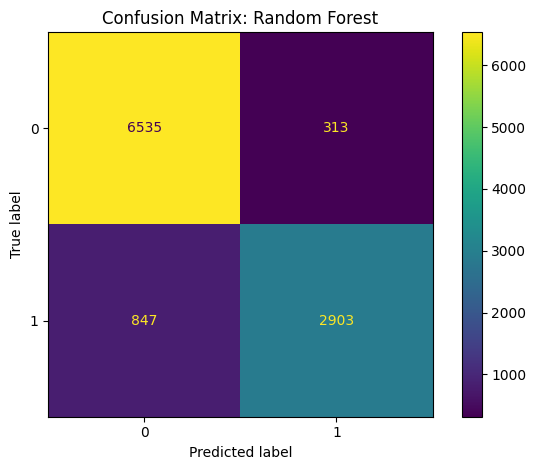

,Model,Best Parameters,Accuracy,Precision,Recall,F1 Score,AUC,Confusion Matrix
0,Random Forest,"{'memory': None, 'steps': [('clf', RandomFores...",0.891,0.903,0.774,0.833,0.953,"[[6535, 313], [847, 2903]]"


In [90]:
# RANDOM FOREST FINETUNING

# Import required packages due to code state reset
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Load the dataset again
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids for tuning
param_grids = {
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }
}

# Base model pipelines
pipelines = {
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# Use F1-score for tuning
scorer = make_scorer(f1_score)

os.makedirs("../reports", exist_ok=True)

# Run GridSearchCV for both models
best_estimators = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X, y)
    best_estimators[name] = grid_search.best_estimator_

# Evaluate the best estimators and extract metrics
evaluation_results = []

for name, model in best_estimators.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    cm = confusion_matrix(y, y_pred)

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"../reports/confusion_matrix_finetuned_{name.lower().replace(' ', '_')}.png")
    plt.show()

    evaluation_results.append({
        "Model": name,
        "Best Parameters": model.get_params(),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Confusion Matrix": cm
    })


    # Save only best tuned hyperparameters
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

# Save metrics
eval_df = pd.DataFrame(evaluation_results)
eval_df.to_csv("../reports/tuned_randomforest_model_metrics_summary.csv", index=False)

eval_df



Test Random forest for overfitting:

In [92]:
# EVALUATE RANDOM FOREST FOR OVERFITTING: 

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split again to have clean train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define a helper function
def evaluate_overfitting(model, name):
    print(f"\nEvaluating {name} for Overfitting:")

    # Train set predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    # Test set predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)

    # Test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    print(f"Training: Accuracy={train_accuracy:.3f}, F1={train_f1:.3f}, AUC={train_auc:.3f}")
    print(f"Testing : Accuracy={test_accuracy:.3f}, F1={test_f1:.3f}, AUC={test_auc:.3f}")

    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Make sure the reports directory exists
    os.makedirs("../reports", exist_ok=True)

    # Save metrics from the most recent evaluation
    rf_test_results = {
        "Model": "Random Forest",
        "Train Accuracy": round(train_accuracy, 3),
        "Train F1 Score": round(train_f1, 3),
        "Train AUC": round(train_auc, 3),
        "Test Accuracy": round(test_accuracy, 3),
        "Test F1 Score": round(test_f1, 3),
        "Test AUC": round(test_auc, 3)
    }

    # Convert to DataFrame and save as CSV
    rf_df = pd.DataFrame([rf_test_results])
    rf_df.to_csv("../reports/random_forest_overfitting_metrics.csv", index=False)

    # Save classification report to TXT
    with open("../reports/random_forest_test_classification_report.txt", "w") as f:
        f.write("Classification Report - Random Forest (Test Set)\n")
        f.write(classification_report(y_test, y_test_pred))

# Run the evaluation
evaluate_overfitting(best_estimators["Random Forest"], "Random Forest")



Evaluating Random Forest for Overfitting:
Training: Accuracy=0.891, F1=0.834, AUC=0.955
Testing : Accuracy=0.889, F1=0.832, AUC=0.946

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1370
           1       0.89      0.78      0.83       750

    accuracy                           0.89      2120
   macro avg       0.89      0.86      0.87      2120
weighted avg       0.89      0.89      0.89      2120



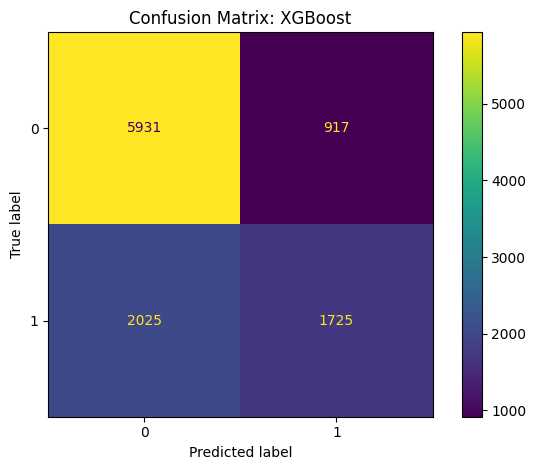

,Model,Best Parameters,Accuracy,Precision,Recall,F1 Score,AUC,Confusion Matrix
0,XGBoost,"{'memory': None, 'steps': [('clf', XGBClassifi...",0.722,0.653,0.46,0.54,0.757,"[[5931, 917], [2025, 1725]]"


In [85]:
# XGBOOST FINETUNING

# Import required packages due to code state reset
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Load the dataset again
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids for tuning
param_grids = {
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    }
}

# Base model pipelines
pipelines = {
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

# Use F1-score for tuning
scorer = make_scorer(f1_score)

os.makedirs("../reports", exist_ok=True)

# Run GridSearchCV for both models
best_estimators_xg = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X, y)
    best_estimators_xg[name] = grid_search.best_estimator_

# Evaluate the best estimators and extract metrics
evaluation_results = []

for name, model in best_estimators_xg.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    cm = confusion_matrix(y, y_pred)

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"../reports/confusion_matrix_finetuned_{name.lower().replace(' ', '_')}.png")
    plt.show()

    evaluation_results.append({
        "Model": name,
        "Best Parameters": model.get_params(),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Confusion Matrix": cm
    })


    # Save only best tuned hyperparameters
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

# Save metrics
eval_df = pd.DataFrame(evaluation_results)
eval_df.to_csv("../reports/tuned_xgboost_model_metrics_summary.csv", index=False)

eval_df


Test XGBoost for Overfitting: 

In [93]:
# EVALUATE XGBOOST FOR OVERFITTING: 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split again to have clean train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define a helper function
def evaluate_overfitting(model, name):
    print(f"\nEvaluating {name} for Overfitting:")

    # Train set predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    # Test set predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)

    # Test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    print(f"Training: Accuracy={train_accuracy:.3f}, F1={train_f1:.3f}, AUC={train_auc:.3f}")
    print(f"Testing : Accuracy={test_accuracy:.3f}, F1={test_f1:.3f}, AUC={test_auc:.3f}")

    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Make sure the reports directory exists
    os.makedirs("../reports", exist_ok=True)

    # Save metrics from the most recent evaluation
    rf_test_results = {
        "Model": "XGBoost",
        "Train Accuracy": round(train_accuracy, 3),
        "Train F1 Score": round(train_f1, 3),
        "Train AUC": round(train_auc, 3),
        "Test Accuracy": round(test_accuracy, 3),
        "Test F1 Score": round(test_f1, 3),
        "Test AUC": round(test_auc, 3)
    }

    # Convert to DataFrame and save as CSV
    rf_df = pd.DataFrame([rf_test_results])
    rf_df.to_csv("../reports/xgboost_overfitting_metrics.csv", index=False)

    # Save classification report to TXT
    with open("../reports/xgboost_test_classification_report.txt", "w") as f:
        f.write("Classification Report - XGBoost (Test Set)\n")
        f.write(classification_report(y_test, y_test_pred))

# ✅ Run the evaluation
evaluate_overfitting(best_estimators_xg["XGBoost"], "XGBoost")



Evaluating XGBoost for Overfitting:
Training: Accuracy=0.721, F1=0.536, AUC=0.755
Testing : Accuracy=0.730, F1=0.553, AUC=0.764

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1370
           1       0.67      0.47      0.55       750

    accuracy                           0.73      2120
   macro avg       0.71      0.67      0.68      2120
weighted avg       0.72      0.73      0.72      2120



Validate and evaluate baseline model:

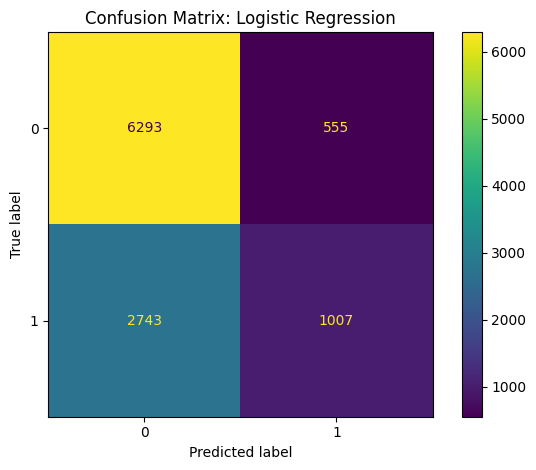


=== Logistic Regression Performance ===
              Model  Accuracy  Precision  Recall  F1 Score   AUC
Logistic Regression     0.689      0.645   0.269     0.379 0.708

Best Parameters:
{
  "clf__C": 10,
  "clf__penalty": "l2",
  "clf__solver": "lbfgs"
}


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Load data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Create output directory
os.makedirs("../reports", exist_ok=True)

# Pipeline
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# Parameter grid
logreg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]  # L2 is only compatible with lbfgs/saga
}

# Grid search
grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X, y)

# Best estimator and prediction
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X)
y_proba = best_logreg.predict_proba(X)[:, 1]

# Metrics
metrics = {
    "Model": "Logistic Regression",
    "Accuracy": round(accuracy_score(y, y_pred), 3),
    "Precision": round(precision_score(y, y_pred), 3),
    "Recall": round(recall_score(y, y_pred), 3),
    "F1 Score": round(f1_score(y, y_pred), 3),
    "AUC": round(roc_auc_score(y, y_proba), 3)
}

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
disp.plot()
plt.title("Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.grid(False)
plt.savefig("../reports/confusion_matrix_logreg.png")
plt.show()

# Save metrics
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("../reports/tuned_baseline_logreg_model_metrics_summary.csv", index=False)

# Save best parameters to JSON
with open("../reports/best_params_logistic_regression.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=2)

# Print results
print("\n=== Logistic Regression Performance ===")
print(metrics_df.to_string(index=False))
print("\nBest Parameters:")
print(json.dumps(grid_search.best_params_, indent=2))



Save the two selected models Random Forest and XGBoost in /models as .pkl file for further processing:

Further validation and evaluation of the two selected models Random Forest and XGBoost.

Debiasing method + fairness metrics
Reflection and interpretation